In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pylab as plt
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier, MLPRegressor

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Slides**

Basics

Intuition

Architectures:
    
    MLP
    
    Conv
    
    RNN
    
    LSTM/GRUs
    
    Attention
    
    Transformers
    
Optimization

Theoretical Results


-----
**Notebook**

Toy problems
    
    Classification
    
    Regression
    
Real problems

    MNIST
    
    MNIST + Convnet
    
    MNIST + autoencoder (MLP)
    
    MNIST + autoencoder (convnet)
    
RNN toy problems

    Linear trend + noise
    
    Quadratic trend + noise
    
    LSTM/GRUs for same problems
    
RNN Autoencoder

    What data?
    
Pytorch + Torchvision


# Goals of this notebook

We want to introduce the basics of neural networks and deep learning. Modern deep learning is a huge field and it's impossible to cover even all the significant developments in the last 5 years here. But the basics are straightforward.

One big caveat: deep learning is a rapidly evolving field. There are new developments in neural network architectures, novel applications, better optimization techniques, theoretical results justifying why something works etc. daily. It's a great opportunity to get involved if you find research interesting and there are great online communities (pytorch, fast.ai, paperswithcode, pysyft) that you should get involved with.

**Note**: Unlike the previous notebooks, this notebook has very few/no questions. You should study the code, tweak the data, the parameters, and poke the models to understand what's going on.

## Synthetic/Artificial Datasets

We covered the basics of neural networks in the lecture. We also saw applications to two synthetic datasets. The goal in this section is to replicate those results and get a feel for using pytorch.

### Classification

In [4]:
def generate_binary_data(N_examples=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    features = []
    target = []

    for i in range(N_examples):
        #class = 0
        r = np.random.uniform()
        theta = np.random.uniform(0, 2*np.pi)

        features.append([r*np.cos(theta), r*np.sin(theta)])
        target.append(0)

        #class = 1
        r = 3 + np.random.uniform()
        theta = np.random.uniform(0, 2*np.pi)

        features.append([r*np.cos(theta), r*np.sin(theta)])
        target.append(1)

    features = np.array(features)
    target = np.array(target)

    return features, target    

In [5]:
features, target = generate_binary_data(seed=100)

In [6]:
def plot_binary_data(features, target):
    plt.figure(figsize=(10,10))
    plt.plot(features[target==0][:,0], features[target==0][:,1], 'p', color='r', label='0')
    plt.plot(features[target==1][:,0], features[target==1][:,1], 'p', color='g', label='1')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

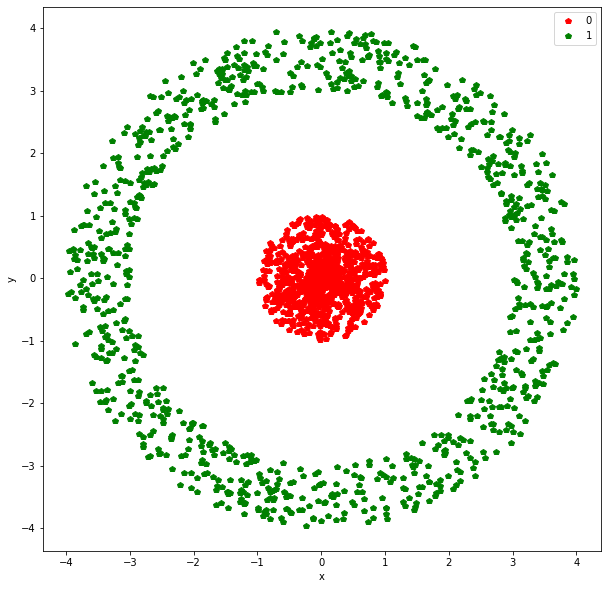

In [7]:
plot_binary_data(features, target)

We have two features here - x and y. There is a binary target variable that we need to predict. This is essentially the dataset during the logistic regression discussion. Logistic regression will not do well here given that the data is not linearly separable. Transforming the data so we have two features:

$$r^2  = x^2 + y^2$$

and

$$\theta = \arctan(\frac{y}{x})$$

would make it very easy to use logistic regression (or just a cut at $r = 2$) to separate the two classes but while it is easy for us to visualize the data and guess at the transformation, in high dimensions, we can't follow the same process.

Let's implement a feed-forward neural network that takes the two features as input and predicts the probabiliy of being in class 1 as output.

#### Architecture Definition

In [8]:
class ClassifierNet(nn.Module): #inherit from nn.Module to define your own architecture
    def __init__(self, N_inputs, N_outputs, N_hidden_layers, N_hidden_nodes, activation, output_activation):
        super(ClassifierNet, self).__init__()
        
        self.N_inputs = N_inputs #2 in our case
        self.N_outputs = N_outputs #1 in our case but can be higher for multi-class classification
        
        self.N_hidden_layers = N_hidden_layers #we'll start by using one hidden layer
        self.N_hidden_nodes = N_hidden_nodes #number of nodes in each hidden layer - can extend to passing a list
        
        #Define layers below - pytorch has a lot of layers pre-defined
        
        #use nn.ModuleList or nn.DictList instead of [] or {} - more explanations below
        self.layer_list = nn.ModuleList([]) #use just as a python list
        for n in range(N_hidden_layers):
            if n==0:
                self.layer_list.append(nn.Linear(N_inputs, N_hidden_nodes))
            else:
                self.layer_list.append(nn.Linear(N_hidden_nodes, N_hidden_nodes))
        
        self.output_layer = nn.Linear(N_hidden_nodes, N_outputs)
        
        self.activation = activation #activations at inner nodes
        self.output_activation = output_activation #activation at last layer (depends on your problem)
        
    def forward(self, inp):
        '''
        every neural net in pytorch has its own forward function
        this function defines how data flows through the architecture from input to output i.e. the forward propagation part
        '''
        
        out = inp
        for layer in self.layer_list:
            out = layer(out) #calls forward function for each layer (already implemented for us)
            out = self.activation(out) #non-linear activation
            
        #pass activations through last/output layer
        out = self.output_layer(out)
        pred = self.output_activation(out)
        
        return pred

There are several ways of specifying a neural net architecture in pytorch. You can work at a high level of abstraction by just listing the layers that you want to getting into the fine details by constructing your own layers (as classes) that can be used in ClassifierNet above.

How does pytorch work? When you define an architecture like the one above, pytorch constructs a graph (nodes and edges) where the nodes are operations on 

In [9]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 2
activation = nn.Sigmoid()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

#### Training

**Loss function**

We first need to pick our loss function. Like we binary classification problems (including logistic regression), we'll use binary cross-entropy:

$$\text{Loss, } L = -\Sigma_{i=1}^{N} y_i \log(p_i) + (1-y_i) \log(1-p_i)$$

where $y_i \in {0,1}$ are the labels and $p_i \in [0,1]$ are the probability predictions.

In [10]:
#look at all available losses (you can always write your own)
torch.nn.*Loss?

In [11]:
criterion = nn.BCELoss()

In [12]:
#target = 1 (label = 1)
print(criterion(torch.tensor(1e-2), torch.tensor(1.))) #pred prob = 1e-2 -> BAD
print(criterion(torch.tensor(0.3), torch.tensor(1.))) #pred prob = 0.3 -> BAd
print(criterion(torch.tensor(0.5), torch.tensor(1.))) #pred prob = 0.5 -> Bad
print(criterion(torch.tensor(1.), torch.tensor(1.))) #pred prob = 1.0 -> GREAT!

tensor(4.6052)
tensor(1.2040)
tensor(0.6931)
tensor(0.)


**Optimizer**:

So we have the data, the neural net architecture, a loss function to measure how well the model does on our task. We also need a way to do gradient descent.

Recall, we use gradient descent to minimize the loss by computing the first derivative (gradients) and taking a step in the direction opposite (since we are minimizing) to the gradient:

$$w_{t} \rightarrow w_{t} - \eta \frac{\partial L}{\partial w_{t-1}}$$

where $w_t$ = weight at time-step t, $L$ = loss, $\eta$ = learning rate.

For our neural network, we first need to calculate the gradients. Thankfully, this is done automatically by pytorch using a procedure called **backpropagation**. If you are interested in more calculations details, please check "automatic differentiation" and an analytical calculation for a feed-forward network (https://treeinrandomforest.github.io/deep-learning/2018/10/30/backpropagation.html).

The gradients are calculated by calling a function **backward** on the network, as we'll see below.

Once the gradients are calculated, we need to update the weights. In practice, there are many heuristics/variants of the update step above that lead to better optimization behavior. A great resource to dive into details is https://ruder.io/optimizing-gradient-descent/. We won't get into the details here.

We'll choose what's called the **Adam** optimizer.

In [13]:
optim.*?

In [14]:
optimizer = optim.Adam(net.parameters(), lr=1e-2)

We picked a constant learning rate here (which is adjusted internally by Adam) and also passed all the tunable weights in the network by using: net.parameters()

In [15]:
list(net.parameters())

[Parameter containing:
 tensor([[-0.4936,  0.2317],
         [ 0.1315,  0.3979]], requires_grad=True), Parameter containing:
 tensor([0.5341, 0.4401], requires_grad=True), Parameter containing:
 tensor([[ 0.4142, -0.6753]], requires_grad=True), Parameter containing:
 tensor([-0.4807], requires_grad=True)]

There are 9 free parameters:

* A 2x2 matrix (4 parameters) mapping the input layer to the 1 hidden layer.

* A 2x1 matrix (2 parameters) mapping the hidden layer to the output layer with one node.

* 2 biases for the 2 nodes in the hidden layer.

* 1 bias for the output node in the output layer.


This is a good place to explain why we need to use nn.ModuleList. If we had just used a vanilla python list, net.parameters() would only show weights that are explicitly defined in our net architecture. The weights and biases associated with the layers would NOT show up in net.parameters(). This process of a module higher up in the hierarchy (ClassifierNet) subsuming the weights and biases of modules lower in the hierarchy (layers) is called **registering**. ModuleList ensures that all the weights/biases are registered as weights and biases of ClassifierNet.

Let's combine all these elements and train our first neural net.

In [16]:
#convert features and target to torch tensors
features = torch.from_numpy(features)
target = torch.from_numpy(target)

In [17]:
#if have gpu, throw the model, features and labels on it
net = net.to(device)
features = features.to(device).float()
target = target.to(device).float()

We need to do the following steps now:

* Compute the gradients for our dataset.

* Do gradient descent and update the weights.

* Repeat till ??

The problem is there's no way of knowing when we have converged or are close to the minimum of the loss function. In practice, this means we keep repeating the process above and monitor the loss as well as performance on a hold-out set. When we start over-fitting on the training set, we stop. There are various modifications to this procedure but this is the essence of what we are doing.

Each pass through the whole dataset is called an **epoch**.

In [18]:
N_epochs = 100
for epoch in range(N_epochs):
    out = net(features) #make predictions on the inputs
    loss = criterion(out, target) #compute loss on our predictions
    
    optimizer.zero_grad() #set all gradients to 0
    loss.backward() #backprop to compute gradients
    optimizer.step() #update the weights
    
    if epoch % 10 == 0:
        print(f'Loss = {loss:.4f}')

Loss = 0.7442
Loss = 0.7142
Loss = 0.6985
Loss = 0.6925
Loss = 0.6902
Loss = 0.6881
Loss = 0.6856
Loss = 0.6828
Loss = 0.6793
Loss = 0.6753


/home/sanjay/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Let's combined all these elements into a function

In [19]:
def train_model(features, target, model, lr, N_epochs, shuffle=False):
    criterion = nn.BCELoss() #binary cross-entropy loss as before
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #Adam optimizer

    #if have gpu, throw the model, features and labels on it
    model = model.to(device)
    features = features.to(device)
    target = target.to(device)

    for epoch in range(N_epochs):
        if shuffle: #should have no effect on gradients in this case
            indices = torch.randperm(len(features))

            features_shuffled = features[indices]
            target_shuffled = target[indices]
        else:
            features_shuffled = features
            target_shuffled = target

        out = model(features_shuffled)
        #out = out.reshape(out.size(0))
        loss = criterion(out, target_shuffled)

        if epoch % 1000 == 0:
            print(f'epoch = {epoch} loss = {loss}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    pred = model(features_shuffled).reshape(len(target))
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0

    #print(f'Accuracy = {accuracy}')
        
    model = model.to('cpu')
    features = features.to('cpu')
    target = target.to('cpu')

    return model

**Exercise**: Train the model and vary the number of hidden nodes and see what happens to the loss. Can you explain this behavior? 

In [23]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 1
activation = nn.Sigmoid()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

net = train_model(features, target, net, 1e-3, 10000)

epoch = 0 loss = 0.7183525562286377
epoch = 1000 loss = 0.641883373260498
epoch = 2000 loss = 0.5926644206047058
epoch = 3000 loss = 0.5665174722671509
epoch = 4000 loss = 0.5521160960197449
epoch = 5000 loss = 0.5434727668762207
epoch = 6000 loss = 0.5379167795181274
epoch = 7000 loss = 0.5341165661811829
epoch = 8000 loss = 0.5313865542411804
epoch = 9000 loss = 0.5293634533882141


In [24]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 2
activation = nn.Sigmoid()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

net = train_model(features, target, net, 1e-3, 10000)

epoch = 0 loss = 0.7931495904922485
epoch = 1000 loss = 0.6682930588722229
epoch = 2000 loss = 0.5827831625938416
epoch = 3000 loss = 0.48574212193489075
epoch = 4000 loss = 0.4137464761734009
epoch = 5000 loss = 0.3623557388782501
epoch = 6000 loss = 0.3256324529647827
epoch = 7000 loss = 0.2993370592594147
epoch = 8000 loss = 0.28050199151039124
epoch = 9000 loss = 0.2670089304447174


In [25]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 3
activation = nn.Sigmoid()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

net = train_model(features, target, net, 1e-3, 10000)

/home/sanjay/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch = 0 loss = 0.7135086059570312
epoch = 1000 loss = 0.6449084877967834
epoch = 2000 loss = 0.3855096399784088
epoch = 3000 loss = 0.2289702445268631
epoch = 4000 loss = 0.1501152664422989
epoch = 5000 loss = 0.10310173034667969
epoch = 6000 loss = 0.07236313074827194
epoch = 7000 loss = 0.05134483426809311
epoch = 8000 loss = 0.036766648292541504
epoch = 9000 loss = 0.026495398953557014


There seems to be some "magic" behavior when we increase the number of nodes in the first (and only) hidden layer from 2 to 3. Loss suddenly goes down dramatically. At this stage, we should explore why that's happening.

For every node in the hidden layer, we have a mapping from the input to that node:

$$\sigma(w_1 x + w_2 y + b)$$

where $w_1, w_2, b$ are specific to that hidden node. We can plot the decision line in this case:

$$w_1 x + w_2 y + b = 0$$

Unlike logistic regression, this is not actually a decision line. Points on one side are not classified as 0 and points on the other side as 1 (if the threshold = 0.5). Instead this line should be thought of as one defining a new coordinate-system. Instead of x and y coordinates, every hidden node induces a straight line and a new coordinate, say $\alpha_i$. So if we have 3 hidden nodes, we are mapping the 2-dimensional input space into a 3-dimensional space where the coordinates $\alpha_1, \alpha_2, \alpha_3$ for each point depend on which side of the 3 lines induced as mentioned above, it lies.

In [26]:
params = list(net.parameters())

In [29]:
print(params[0]) #3x2 matrix
print(params[1]) #3 biases

Parameter containing:
tensor([[-2.9927,  3.6568],
        [-4.5762, -0.6465],
        [ 1.5131,  4.0023]], requires_grad=True)
Parameter containing:
tensor([ 6.4458, -6.2897, -6.0999], requires_grad=True)


In [32]:
features = features.detach().cpu().numpy() #detach from pytorch computational graph, bring back to cpu, convert to numpy
target = target.detach().cpu().numpy()

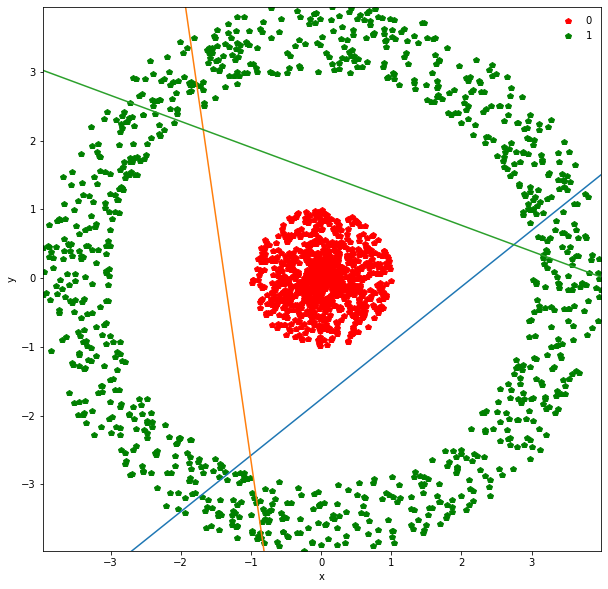

In [40]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot()

#plot raw data
ax.plot(features[target==0][:,0], features[target==0][:,1], 'p', color='r', label='0')
ax.plot(features[target==1][:,0], features[target==1][:,1], 'p', color='g', label='1')

plt.xlabel('x')
plt.ylabel('y')

#get weights and biases
weights = params[0].detach().numpy()
biases = params[1].detach().numpy()

#plot straight lines
x_min, x_max = features[:,0].min(), features[:,0].max()
y_lim_min, y_lim_max = features[:,1].min(), features[:,1].max()
for i in range(weights.shape[0]): #loop over each hidden node in the one hidden layer
    coef = weights[i]
    intercept = biases[i]
    
    y_min = (-intercept - coef[0]*x_min)/coef[1]
    y_max = (-intercept - coef[0]*x_max)/coef[1]
    
    ax.plot([x_min, x_max], [y_min, y_max])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_lim_min, y_lim_max)
ax.legend(framealpha=0)

This is the plot we showed in the lecture. For every hidden node in the hidden layer, we have a straight line. The colors of the three lines above are orange, green and blue and that's what we'll call our new coordinates.

Suppose you pick a point in the red region:

* It lies to the *right* of the orange line

* It lies to the *bottom* of the green line

* It lies to the *top* of the blue line.

On the other hand, we have **6** green regions. If you start walking clockwise from the top green section, every time you cross a straight line, you walk into a new region. Each time you walk into a new region, you flip the coordinate of one of the 3 lines. Either you go from *right* to *left* of the orange line, *bottom* to *top* of the green line or *top* to *bottom* of the blue line.

So instead of describing each point by two coordinates (x, y), we can describe it by (orange status, green status, blue status). We happen to have 7 such regions here - with 1 being purely occupied by the red points and the other 7 by green points.

This might be become cleared from a 3-dimensional plot.

In [44]:
from mpl_toolkits.mplot3d import Axes3D

In [55]:
#get hidden layer activations for all inputs
features_layer1_3d = net.activation(net.layer_list[0](torch.tensor(features))).detach().numpy()
print(features_layer1_3d[0:10])

[[9.9983168e-01 2.0363766e-03 1.6217586e-02]
 [6.3131476e-05 1.7652790e-06 4.8456849e-07]
 [9.9841797e-01 1.8193906e-03 2.2791103e-03]
 [2.6953128e-05 6.8769059e-06 6.1394964e-08]
 [9.9861813e-01 3.3604328e-03 1.4527501e-03]
 [1.0000000e+00 1.7814623e-06 9.9997127e-01]
 [9.9840850e-01 8.8937895e-04 4.4292780e-03]
 [9.1963178e-03 1.1174900e-09 4.7539290e-02]
 [9.9963665e-01 2.0298058e-04 6.5633811e-02]
 [1.0000000e+00 2.2442194e-03 9.9970526e-01]]


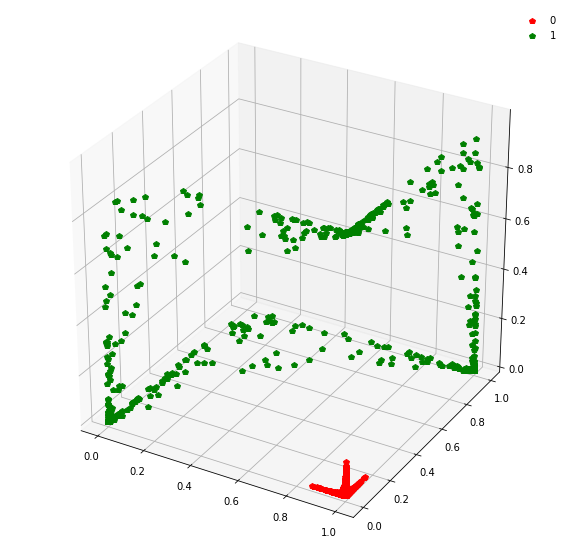

In [59]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

ax.plot(features_layer1_3d[target==0][:,0], features_layer1_3d[target==0][:,1], features_layer1_3d[target==0][:,2], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,0], features_layer1_3d[target==1][:,1], features_layer1_3d[target==1][:,2], 'p', color ='g', label='1')

ax.legend(framealpha=0)

At this stage, a simple linear classifier can draw a linear decision boundary (a plane) to separate the red points from the green points. Also, these points lie in the unit cube (cube with sides of length=1) since we are using sigmoid activations. Whenever the activations get saturated (close to 0 or 1), then we see points on the edges and corners of the cube.

**Question**: Switch the activation from sigmoid to relu (nn.ReLU()). Does the loss still essentially become zero on the train set? If not, try increasing N_hidden_nodes. At what point does the loss actually become close to 0?

In [69]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 5
activation = nn.ReLU()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

features = torch.tensor(features)
target = torch.tensor(target)

net = train_model(features, target, net, 1e-3, 10000)

/home/sanjay/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/sanjay/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


epoch = 0 loss = 0.7162193059921265
epoch = 1000 loss = 0.09184534102678299
epoch = 2000 loss = 0.018247773870825768
epoch = 3000 loss = 0.006626652088016272
epoch = 4000 loss = 0.003010569140315056
epoch = 5000 loss = 0.001521119847893715
epoch = 6000 loss = 0.0008111244533210993
epoch = 7000 loss = 0.00044749872176907957
epoch = 8000 loss = 0.00025160337099805474
epoch = 9000 loss = 0.00014362987712956965


**Question**: Remake the 3d plot but by trying 3 coordinates out of the N_hidden_nodes coordinates you found above?

In [72]:
features = features.detach().cpu().numpy() #detach from pytorch computational graph, bring back to cpu, convert to numpy
target = target.detach().cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

[[ 0.          0.          0.49347013  3.987105    0.45143852]
 [ 0.          9.150797    0.          3.0220006   0.        ]
 [ 0.          0.          0.          3.7095528   0.        ]
 [ 0.         10.179764    0.          2.617361    0.        ]
 [ 0.          0.          0.          3.5965369   0.        ]
 [ 0.          0.          2.846237    6.6425385   9.958172  ]
 [ 0.          0.          0.          3.8616483   0.1923224 ]
 [ 0.          3.2984982   0.          5.264724    6.828571  ]
 [ 0.          0.          0.          4.375891    2.0520163 ]
 [ 0.          0.          7.1362004   5.7518415   5.988157  ]]


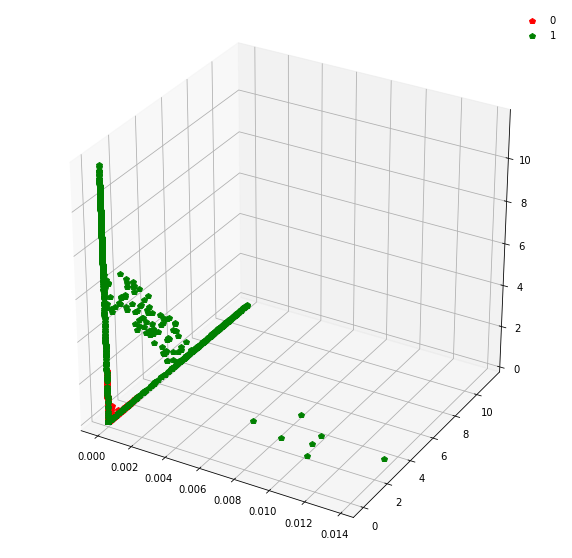

In [76]:
#get hidden layer activations for all inputs
features_layer1_3d = net.activation(net.layer_list[0](torch.tensor(features))).detach().numpy()

print(features_layer1_3d[0:10])

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

COORD1 = 0
COORD2 = 1
COORD3 = 2

ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

ax.legend(framealpha=0)

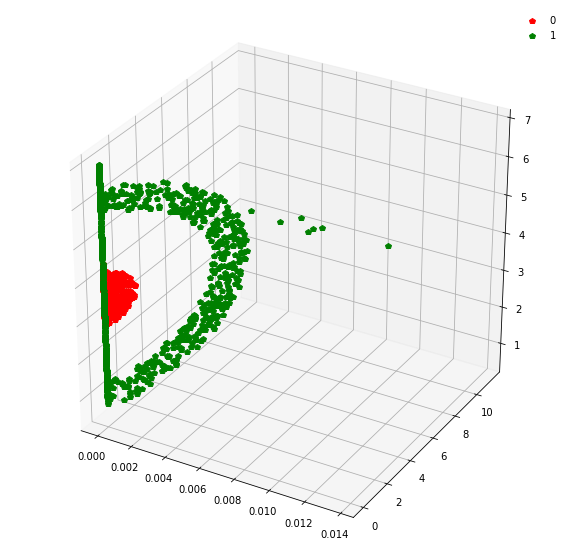

In [77]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

COORD1 = 0
COORD2 = 1
COORD3 = 3

ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

ax.legend(framealpha=0)

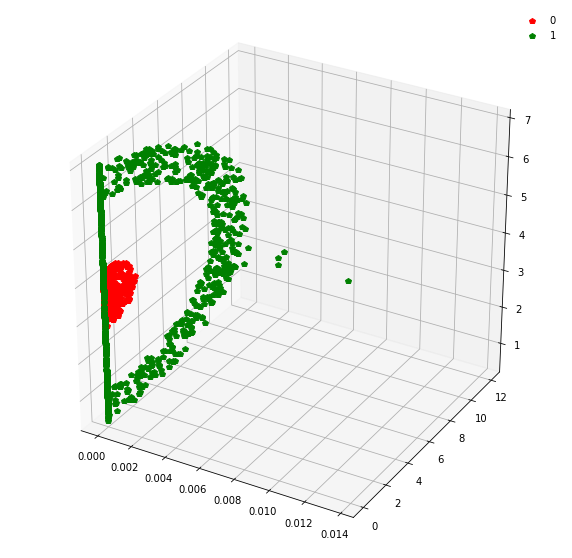

In [78]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

COORD1 = 0
COORD2 = 2
COORD3 = 3

ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

ax.legend(framealpha=0)

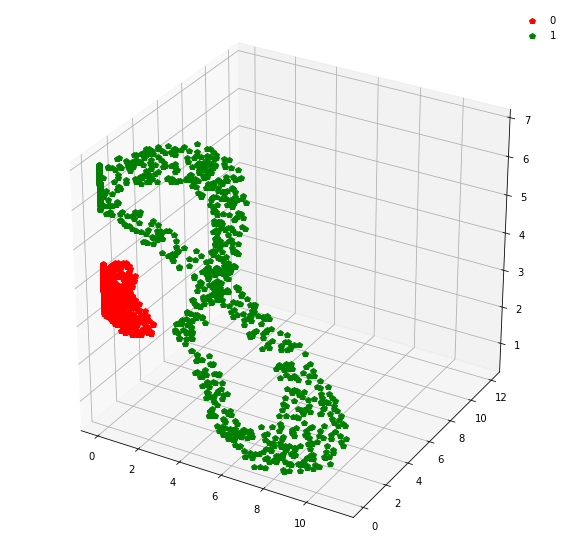

In [79]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

COORD1 = 1
COORD2 = 2
COORD3 = 3

ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

ax.legend(framealpha=0)